# Importing Libraries

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import librosa
import librosa.display
import cv2
from PIL import Image

from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import utils as np_utils
import os
from os import listdir
from os.path import isfile, join
import copy
import random

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import MaxPool2D, Reshape, Concatenate
from tensorflow.keras.regularizers import l2

import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Loading Dataset

In [3]:
W = 224
H = 224
label_to_class = {
    'BACTERIAL PNEUMONIA': 0,
    'COVID':       1,
    'NORMAL':    2,
    'PNEUMOTHORAX': 3,
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='/kaggle/input/cxr-classification/DS-5', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [4]:
Images, Classes = get_images()

Images.shape, Classes.shape

((6000, 224, 224, 3), (6000,))

# Data Visualization

BACTERIAL PNEUMONIA 1500 0.25


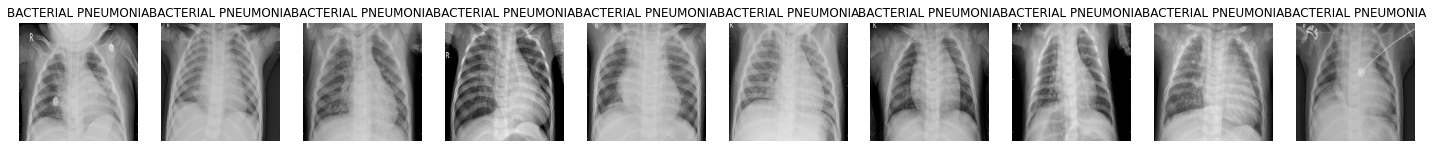

COVID 1500 0.25


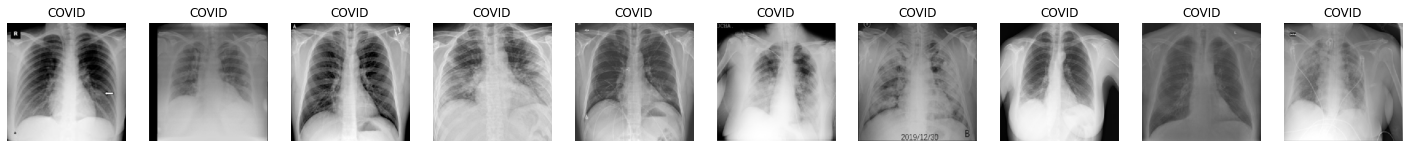

NORMAL 1500 0.25


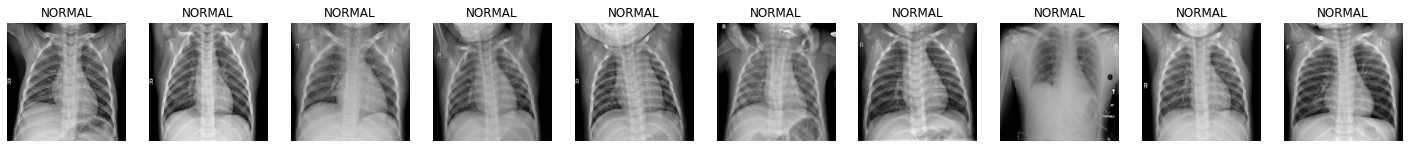

PNEUMOTHORAX 1500 0.25


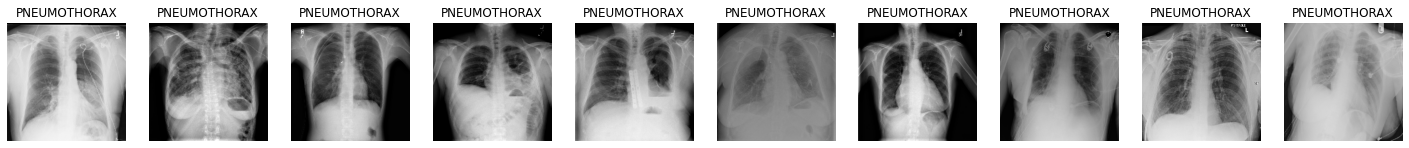

In [5]:
n_total_images = Images.shape[0]

for target_cls in [0,1,2,3]:
    
    indices = np.where(Classes == target_cls)[0] 
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 10 
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

# Train-Test Split

In [6]:
train_set, validation_test_set = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, random_state=42, shuffle=False)
validation_set, test_set = train_test_split(validation_test_set, test_size=0.5, random_state=42, shuffle=False)

x_train = Images[train_set]
y_train = Classes[train_set]
x_validation = Images[validation_set]
y_validation = Classes[validation_set]
x_test = Images[test_set]
y_test = Classes[test_set]

y_train = np_utils.to_categorical(y_train, n_classes)
y_validation = np_utils.to_categorical(y_validation, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

In [7]:
image_data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        samplewise_center=True, 
        samplewise_std_normalization= True, 
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2
    )

# CNN Model

In [8]:
def cnn_model():

    print("----Building the model----")
    i = Input(shape=(224,224,3)) 
    x = BatchNormalization()(i)
     
    x = Conv2D(64,3, activation= 'relu')(x)
    x = Conv2D(64,3, activation= 'relu')(x) 
    x = MaxPooling2D()(x)

        
    x = Conv2D(128, 3, activation='relu')(x)
    x = Conv2D(128,3, activation= 'relu')(x) 
    x = MaxPooling2D()(x)
    
    x = Conv2D(256, 3, activation='relu')(x)
    x = Conv2D(256,3, activation= 'relu')(x) 
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, 3, activation='relu')(x)
    x = Conv2D(512,3, activation= 'relu')(x) 
    x = MaxPooling2D()(x)
      
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(1024,name ='feature_dense', activation='relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()

    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', 
                            mode='min', 
                            patience = 10 ,
                            restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('CNN_V4.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(image_data_generator.flow(x_train, y_train), 
                validation_data = image_data_generator.flow(x_validation, y_validation), 
                epochs = 25, 
                verbose = 1,
                batch_size = 16,
                callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(image_data_generator.flow(x_train, y_train)))
    print("Validation score:", model.evaluate(image_data_generator.flow(x_validation, y_validation)))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

r,model,n_epochs = cnn_model()
model.save("CNN_V4.h5")

----Building the model----


2022-12-06 15:46:39.279819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 15:46:39.281518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 15:46:39.282507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 15:46:39.283747: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 128)     147584

2022-12-06 15:46:44.987578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-06 15:46:46.943797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


150/150 [==============================] - 38s 181ms/step - loss: 0.7582 - accuracy: 0.6673 - val_loss: 0.5075 - val_accuracy: 0.8000

Epoch 00001: val_loss improved from inf to 0.50749, saving model to CNN_V4.h5
Epoch 2/25
150/150 [==============================] - 25s 167ms/step - loss: 0.4995 - accuracy: 0.7965 - val_loss: 0.3410 - val_accuracy: 0.8700

Epoch 00002: val_loss improved from 0.50749 to 0.34100, saving model to CNN_V4.h5
Epoch 3/25
150/150 [==============================] - 25s 166ms/step - loss: 0.3909 - accuracy: 0.8558 - val_loss: 0.2689 - val_accuracy: 0.9133

Epoch 00003: val_loss improved from 0.34100 to 0.26892, saving model to CNN_V4.h5
Epoch 4/25
150/150 [==============================] - 25s 164ms/step - loss: 0.3175 - accuracy: 0.8875 - val_loss: 0.2630 - val_accuracy: 0.9167

Epoch 00004: val_loss improved from 0.26892 to 0.26298, saving model to CNN_V4.h5
Epoch 5/25
150/150 [==============================] - 25s 165ms/step - loss: 0.2469 - accuracy: 0.9160 

In [9]:
test_evaluation = model.evaluate(image_data_generator.flow(x_test, y_test))
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

19/19 [==============================] - 2s 101ms/step - loss: 0.1211 - accuracy: 0.9783
Test Accuracy using CNN: 97.83%


In [10]:
train_evaluation = model.evaluate(image_data_generator.flow(x_train, y_train))
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

validation_evaluation = model.evaluate(image_data_generator.flow(x_validation, y_validation))
print(f"Validation Accuracy using CNN: {validation_evaluation[1] * 100:.2f}%")

150/150 [==============================] - 14s 94ms/step - loss: 0.0189 - accuracy: 0.9929
Train Accuracy using CNN: 99.29%
19/19 [==============================] - 2s 83ms/step - loss: 0.0886 - accuracy: 0.9750
Validation Accuracy using CNN: 97.50%


# Learning Curve

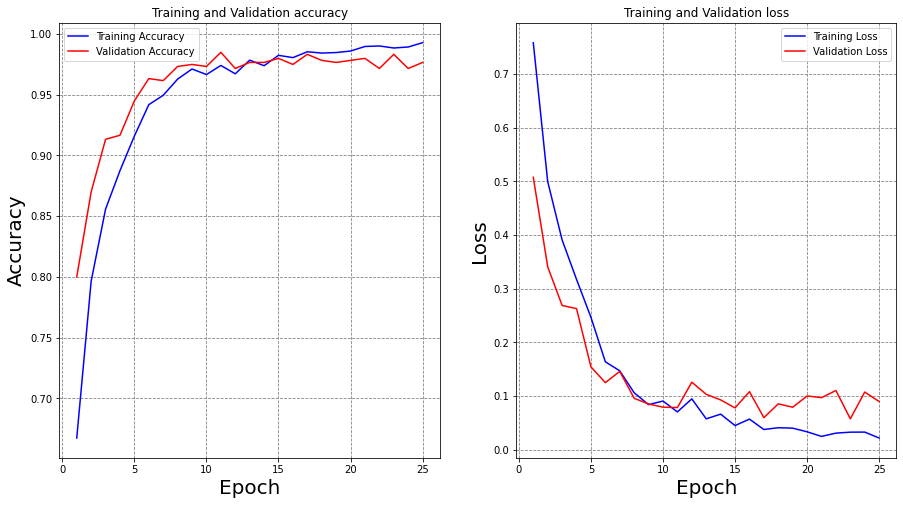

In [11]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(15,8))
    
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')

  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
    
  plt.show()
plotLearningCurve(r,n_epochs)

# Confusion Matrix

2022-12-06 15:58:16.292513: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.
2022-12-06 15:58:16.922020: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.


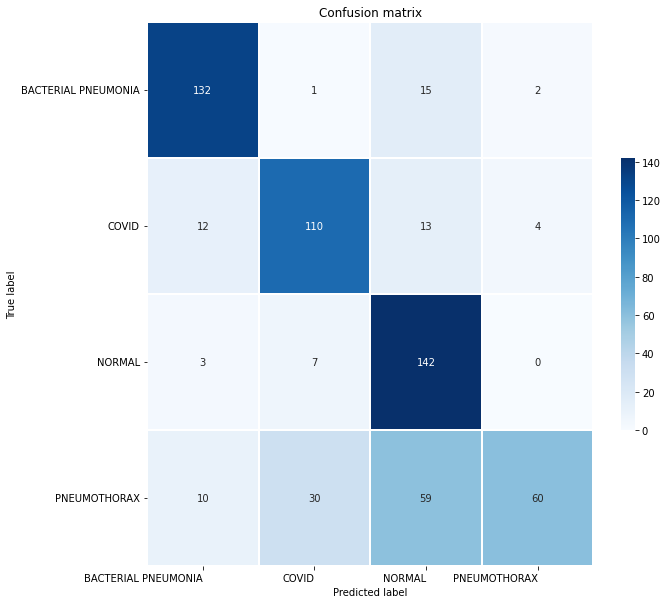

In [12]:
## plot confusion matrix
import copy

x = preprocess_input(copy.deepcopy(x_test))
y_preds = model.predict(x)
k = np.argmax(y_preds)
p = np.max(y_preds)

y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)


fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .5}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='Confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=0, ha='right', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [13]:
x_test_2 = copy.deepcopy(x_test)
x = preprocess_input(x_test_2)
y_preds = model.predict(x)
y_preds = np.argmax(y_preds, axis=1)
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
dic = {0:'BACTERIAL PNEUMONIA', 1:'COVID', 2:'NORMAL', 3:'PNEUMOTHORAX'}

print(classification_report(rounded_labels, y_preds, target_names=dic.values()))

2022-12-06 15:58:19.724929: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.
2022-12-06 15:58:20.158808: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.


                     precision    recall  f1-score   support

BACTERIAL PNEUMONIA       0.84      0.88      0.86       150
              COVID       0.74      0.79      0.77       139
             NORMAL       0.62      0.93      0.75       152
       PNEUMOTHORAX       0.91      0.38      0.53       159

           accuracy                           0.74       600
          macro avg       0.78      0.75      0.73       600
       weighted avg       0.78      0.74      0.72       600



# ROC Curve

2022-12-06 15:58:22.511311: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 361267200 exceeds 10% of free system memory.


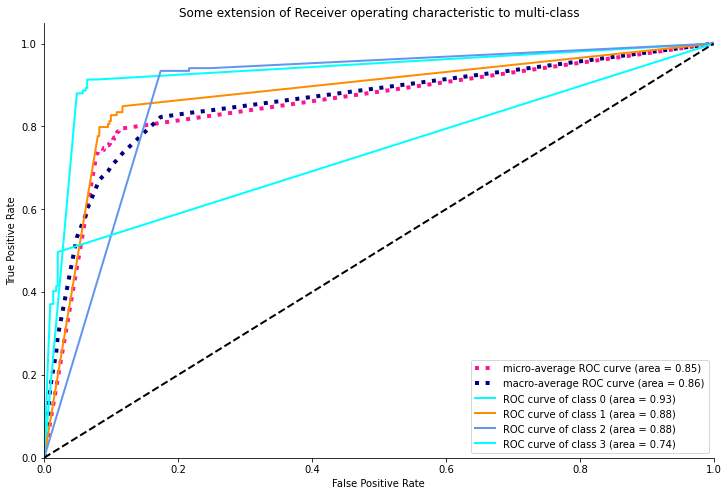

In [14]:
fpr = {}
tpr = {}
thresh ={}

n_classes = 4


x_test_2 = copy.deepcopy(x_test)
x = preprocess_input(x_test_2)
pred_Y = model.predict(x)


lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

# Heatmap with Grad-CAM

In [15]:
def _plot(model, cam_func, img, cls_true):
    """plot original image, heatmap from cam and superimpose image"""
    
    # for cam
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(copy.deepcopy(x))

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(model=model, x=x, layer_name=model.layers[-2].name)
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('Heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('Superimposed image')
    axs[2].axis('off')

    plt.suptitle('True label: ' + class_to_label[cls_true] + ' / Predicted label : ' + class_to_label[cls_pred])
    plt.tight_layout()
    plt.show()

In [16]:



def preprocess_img(img, size):



    img = cv2.imread(img)
    img = cv2.resize(img, size)
    img = img.astype('float32') / 255
    


    return img

def expand_dims(img_path, size):

    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def gradcam_superimpose(img_path, heatmap, size, alpha=0.4):

    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


    superimposed_img = superimposed_img.resize(size)

    

    return superimposed_img

input_1
batch_normalization
conv2d
conv2d_1
max_pooling2d
conv2d_2
conv2d_3
max_pooling2d_1
conv2d_4
conv2d_5
max_pooling2d_2
conv2d_6
conv2d_7
max_pooling2d_3
flatten
dense
dropout
feature_dense
dropout_1
dense_1


<Figure size 1080x432 with 0 Axes>

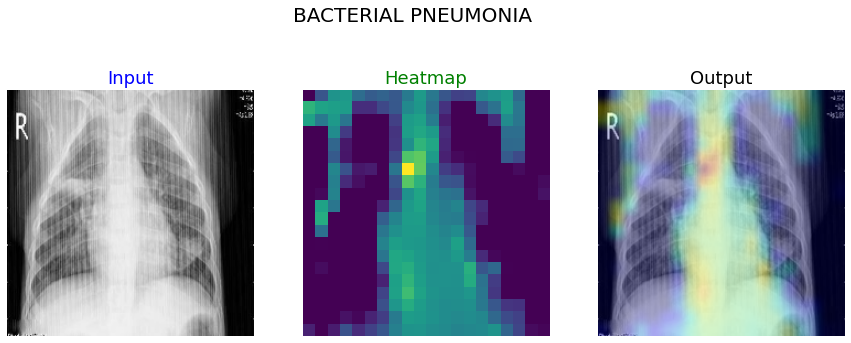

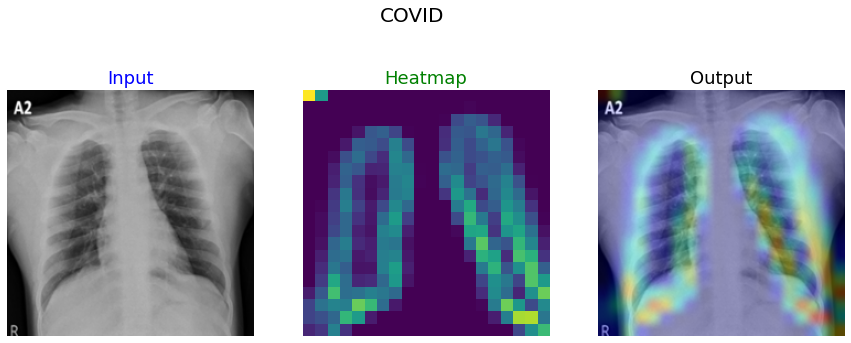

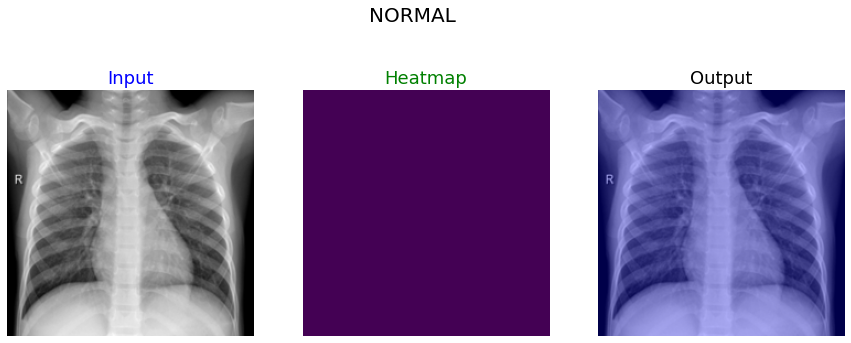

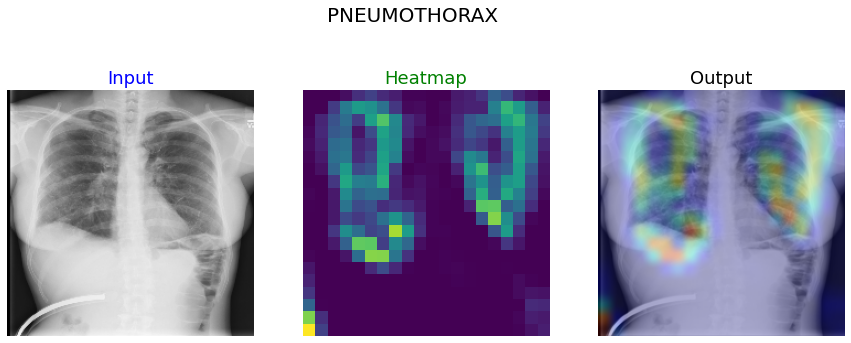

In [47]:
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

gradcam_labels = [
    'BACTERIAL PNEUMONIA',
    'COVID',
    'NORMAL',
    'PNEUMOTHORAX'
]

for idx in range(len(model.layers)):
    print(model.get_layer(index = idx).name)


model = tf.keras.models.load_model('CNN_V4.h5')
last_conv_layer_name = "conv2d_7"
img_size = (224, 224)

# Remove last layer's softmax
model.layers[-1].activation = None



for i in range(4):

    img_url = [
        "/kaggle/input/cxr-classification/DS-5/BACTERIAL PNEUMONIA/Pneumonia-Bacterial (123).jpg",
        "/kaggle/input/cxr-classification/DS-5/COVID/COVID-136.png",
        "/kaggle/input/cxr-classification/DS-5/NORMAL/Normal-1067.png",
        "/kaggle/input/cxr-classification/DS-5/PNEUMOTHORAX/00004727_001.png"
                ]

    heatmaps = []
    images = []
    outputs = []


    img_path = img_url[i]


    img_array = preprocess_input(expand_dims(img_path, size=img_size))


    for k in range(1):

        arr_layer = [4]

        image = preprocess_img(img_url[i], img_size)

        preds = model.predict(img_array) 
       
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        output = gradcam_superimpose(img_path, heatmap, img_size)


        images.append(image)
        heatmaps.append(heatmap)
        outputs.append(output)



    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 6)
    fig, ax = plt.subplots(1, 3)

    fig.suptitle(gradcam_labels[i], fontsize=20)

    ax[0].set_title('Input', loc='center', color='blue', fontsize=18)
    ax[1].set_title('Heatmap', loc='center', color='green', fontsize=18)
    ax[2].set_title('Output', loc='center', color='black', fontsize=18)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')


    ax[0].imshow(images[0])
    ax[1].imshow(heatmaps[0])
    ax[2].imshow(outputs[0])

    images.clear()
    heatmaps.clear()
    outputs.clear()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 6)

plt.show()